<a href="https://colab.research.google.com/github/eomjimin/KDT_HW/blob/main/sportsBalls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'jimineom'
os.environ['KAGGLE_KEY'] = '954b78da1444497c4d761a57f9e591c0'

In [ ]:
!kaggle datasets download -d samuelcortinhas/sports-balls-multiclass-image-classification

 96% 386M/401M [00:02<00:00, 238MB/s]
100% 401M/401M [00:02<00:00, 188MB/s]


In [ ]:
!unzip -q sports-balls-multiclass-image-classification.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        # 각도, 찌그러뜨림, 크기
        transforms.RandomAffine(0, shear = 10, scale=(0.8, 1.2)), # 특정 이미지를 랜덤하게 뽑아서 변환
        # 수평으로 뒤집기
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

image_datasets = {
    'train': datasets.ImageFolder('./train', data_transforms['train']),
    'validation': datasets.ImageFolder('./test', data_transforms['validation'])
}

In [ ]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [ ]:
print(len(image_datasets['train']), len(image_datasets['validation']))

7328 1841


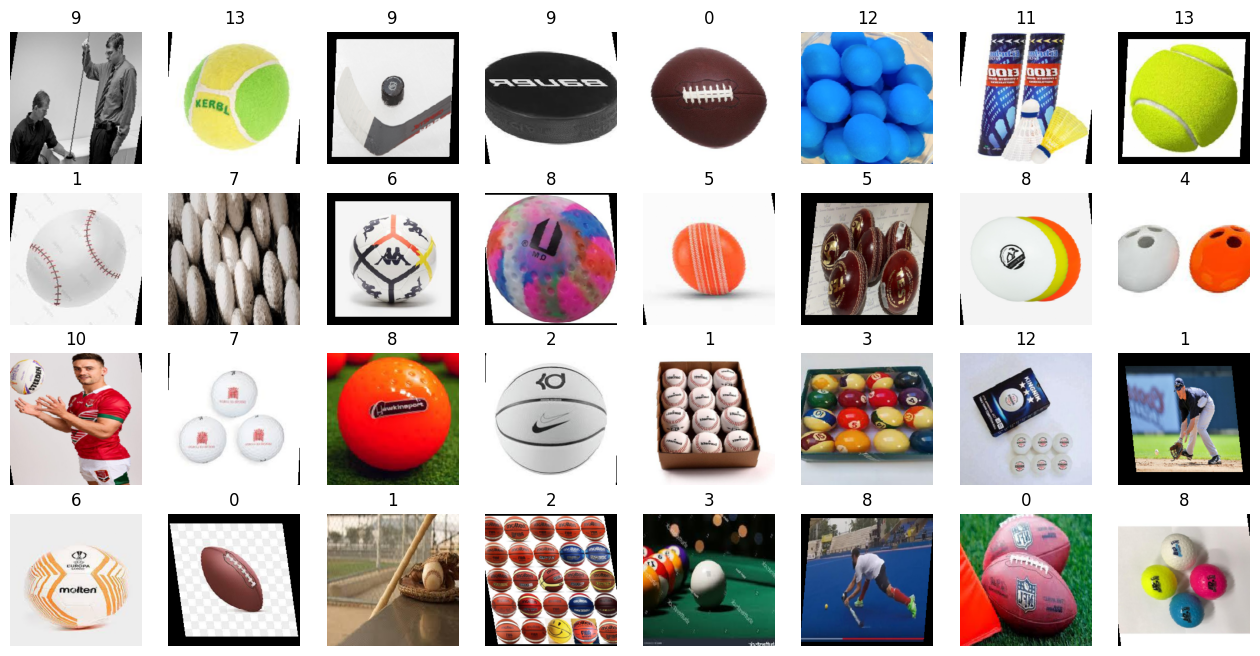

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for ax, img, label in zip(axes.flatten(), imgs, labels):
  ax.imshow(img.permute(1,2,0))
  ax.set_title(label.item())
  ax.axis('off')

In [ ]:
model = models.densenet121(weights='IMAGENET1K_V1').to(device)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
for param in model.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 15)
).to(device)

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

epochs=10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.CrossEntropyLoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()
            y_prob = nn.Softmax(1)(y_pred)
            y_pred_index = torch.argmax(y_prob, axis=1)
            acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')



train     : Epoch    1/10, Loss: 1.2628, Accuracy: 60.90%
validation: Epoch    1/10, Loss: 0.7830, Accuracy: 74.57%
train     : Epoch    2/10, Loss: 0.7390, Accuracy: 77.05%
validation: Epoch    2/10, Loss: 0.6792, Accuracy: 78.09%
train     : Epoch    3/10, Loss: 0.6363, Accuracy: 79.45%
validation: Epoch    3/10, Loss: 0.6552, Accuracy: 80.08%
train     : Epoch    4/10, Loss: 0.5925, Accuracy: 81.06%
validation: Epoch    4/10, Loss: 0.6646, Accuracy: 80.29%
train     : Epoch    5/10, Loss: 0.5387, Accuracy: 83.09%
validation: Epoch    5/10, Loss: 0.5970, Accuracy: 81.37%
train     : Epoch    6/10, Loss: 0.4870, Accuracy: 84.63%
validation: Epoch    6/10, Loss: 0.5669, Accuracy: 83.59%
train     : Epoch    7/10, Loss: 0.4535, Accuracy: 85.70%
validation: Epoch    7/10, Loss: 0.6512, Accuracy: 81.80%
train     : Epoch    8/10, Loss: 0.4208, Accuracy: 86.46%
validation: Epoch    8/10, Loss: 0.6239, Accuracy: 81.22%
train     : Epoch    9/10, Loss: 0.4118, Accuracy: 86.37%
validation: Ep

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([self._make_layer(in_channels + i * growth_rate, growth_rate) for i in range(num_layers)])

    def _make_layer(self, in_channels, out_channels):
        return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            x = layer(torch.cat(features, 1))
            features.append(x)
        return torch.cat(features, 1)

class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate=32):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, growth_rate, kernel_size=3, padding=1, bias=False)
        self.dense1 = DenseBlock(growth_rate, growth_rate, num_blocks[0])
        self.transition1 = self._make_transition(growth_rate * (num_blocks[0] + 1))
        self.dense2 = DenseBlock(growth_rate, growth_rate, num_blocks[1])
        self.transition2 = self._make_transition(growth_rate * (num_blocks[1] + 1))
        self.dense3 = DenseBlock(growth_rate, growth_rate, num_blocks[2])
        self.transition3 = self._make_transition(growth_rate * (num_blocks[2] + 1))
        self.dense4 = DenseBlock(growth_rate, growth_rate, num_blocks[3])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(growth_rate * (num_blocks[3] + 1), 10)  # 10은 예시로, 클래스 수에 맞게 조절

    def _make_transition(self, in_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.dense1(x)
        x = self.transition1(x)
        x = self.dense2(x)
        x = self.transition2(x)
        x = self.dense3(x)
        x = self.transition3(x)
        x = self.dense4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 모델 인스턴스 생성
num_blocks = [6, 12, 24, 16]  # 각 DenseBlock에 포함된 레이어의 수
densenet_model = DenseNet(num_blocks)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class DenseNet121Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet121Model, self).__init__()
        # Pre-trained DenseNet121 모델을 불러오기
        self.densenet121 = models.densenet121(pretrained=True)

        # 마지막 fully connected layer의 입력 크기를 수정하여 원하는 클래스 수에 맞추기
        in_features = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Forward pass를 정의
        x = self.densenet121(x)
        return x

# 모델 생성 및 예제 출력
num_classes = 10  # 분류할 클래스 수에 맞게 설정
model = DenseNet121Model(num_classes)

# 모델 구조 출력
print(model)